In [1]:
import os
import torch
from types import SimpleNamespace

config = SimpleNamespace(
    data_dir="/mnt/d/datasets/mvtec",
    category="tile",
    batch_size=16,
    img_size=256,
    latent_dim=1024,
    num_epochs=50,
    learning_rate=1e-3,
    weight_decay=1e-5,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
)
config.output_dir = f"results_{config.category}"
os.makedirs(config.output_dir, exist_ok=True)
config

namespace(data_dir='/mnt/d/datasets/mvtec',
          category='tile',
          batch_size=16,
          img_size=256,
          latent_dim=1024,
          num_epochs=50,
          learning_rate=0.001,
          weight_decay=1e-05,
          device=device(type='cuda'),
          output_dir='results_tile')

In [2]:
import matplotlib.pyplot as plt


def denormalize_imagenet(tensor):
    device = tensor.device
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(-1, 1, 1)
    return torch.clamp(tensor * std + mean, 0.0, 1.0)


def save_reconstruction_samples(original, reconstructed, epoch, model_type='AE', save_dir="samples"):
    os.makedirs(save_dir, exist_ok=True)

    fig, axes = plt.subplots(2, 4, figsize=(8, 3.5))

    for i in range(min(4, original.size(0))):
        # Denormalize for visualization
        orig_denorm = denormalize_imagenet(original[i:i+1])[0]
        recon_denorm = denormalize_imagenet(reconstructed[i:i+1])[0]

        # Original
        axes[0, i].imshow(orig_denorm.cpu().permute(1, 2, 0))
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis('off')

        # Reconstructed
        axes[1, i].imshow(recon_denorm.cpu().detach().permute(1, 2, 0))
        axes[1, i].set_title(f"Reconstructed {i+1}")
        axes[1, i].axis('off')

    plt.suptitle(f"{model_type} Reconstruction - Epoch {epoch} (ImageNet Norm)")
    fig.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{model_type}_epoch_{epoch}.png"))
    plt.close()

In [3]:
import numpy as np

def compute_anomaly_scores(anomaly_map, method='max_pooling'):
    if method == 'max_pooling':
        scores = torch.amax(anomaly_map.view(anomaly_map.size(0), -1), dim=1)
    elif method == 'percentile_95':
        flattened = anomaly_map.view(anomaly_map.size(0), -1)
        scores = torch.quantile(flattened, q=0.95, dim=1)
    elif method == 'topk_mean':
        flattened = anomaly_map.view(anomaly_map.size(0), -1)
        k = max(1, int(0.01 * flattened.size(1)))
        topk_values, _ = torch.topk(flattened, k=k, dim=1)
        scores = torch.mean(topk_values, dim=1)
    elif method == 'mean':
        scores = anomaly_map.view(anomaly_map.size(0), -1).mean(dim=1)
    else:
        scores = torch.amax(anomaly_map.view(anomaly_map.size(0), -1), dim=1)
    return scores


@torch.no_grad()
def trainer_predict(model, test_loader, device, method='max_pooling'):
    model.eval()
    all_scores = []
    all_labels = []

    for images, labels in test_loader:
        images = images.to(device)
        reconstructed = model(images)
        anomaly_map = torch.mean((images - reconstructed)**2, dim=1)
        scores = compute_anomaly_scores(anomaly_map, method=method)

        all_scores.extend(scores.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return np.array(all_scores), np.array(all_labels)


def trainer_fit(model, optimizer, loss_fn, train_loader, device, num_epochs=10):
    model.train()
    history = {"loss": []}

    for epoch in range(1, num_epochs + 1):
        epoch_loss = 0.0
        num_batches = 0

        for images, _ in train_loader:
            images = images.to(device)

            optimizer.zero_grad()
            reconstructed = model(images)
            loss = loss_fn(reconstructed, images)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        history["loss"].append(avg_loss)

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] loss: {avg_loss:.2e}")
            save_reconstruction_samples(images, reconstructed, epoch, model_type="AE",
                save_dir="samples")
            
            with torch.no_grad():
                sample_images = images[:2]
                sample_reconstructed = model(sample_images)
                print(f"  Input:  [{sample_images.min():.3f}, {sample_images.max():.3f}]")
                print(f"  Output: [{sample_reconstructed.min():.3f}, {sample_reconstructed.max():.3f}]")
    return history

In [4]:
import torch.nn as nn
import torch.optim as optim

from dataloaders import get_dataloaders
from models import VanillaAE

train_loader, test_loader = get_dataloaders(
    config.data_dir, config.category, config.batch_size, config.img_size)
model = VanillaAE(latent_dim=config.latent_dim, input_size=config.img_size)
model = model.to(config.device)
optimizer = optim.AdamW(model.parameters(), 
    lr=config.learning_rate, weight_decay=config.weight_decay)
loss_fn = nn.MSELoss()

history = trainer_fit(model, optimizer, loss_fn, train_loader, 
    device=config.device, num_epochs=config.num_epochs)

train set: 230 images, Normal: 230, Anomaly: 0
test set: 117 images, Normal: 33, Anomaly: 84
Epoch [10/50] loss: 3.01e-01
  Input:  [-1.262, 1.437]
  Output: [-0.810, 2.640]
Epoch [20/50] loss: 2.56e-01
  Input:  [-1.262, 1.803]
  Output: [-0.672, 1.511]
Epoch [30/50] loss: 1.68e-01
  Input:  [-1.347, 2.640]
  Output: [-1.276, 1.466]
Epoch [40/50] loss: 1.15e-01
  Input:  [-1.330, 1.681]
  Output: [-1.286, 1.917]
Epoch [50/50] loss: 7.62e-02
  Input:  [-1.262, 2.394]
  Output: [-1.426, 1.497]


In [5]:
from utils import (show_history, show_roc_curve, show_distribution, 
                   show_evaluation, show_statistics)

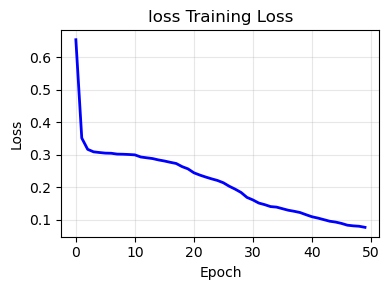

In [6]:
show_history(history)

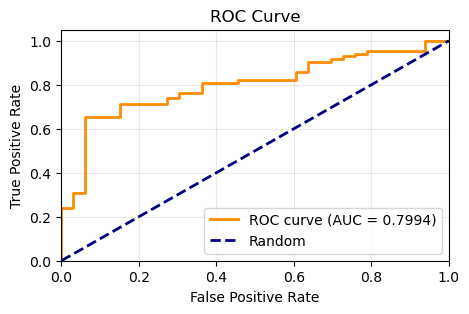

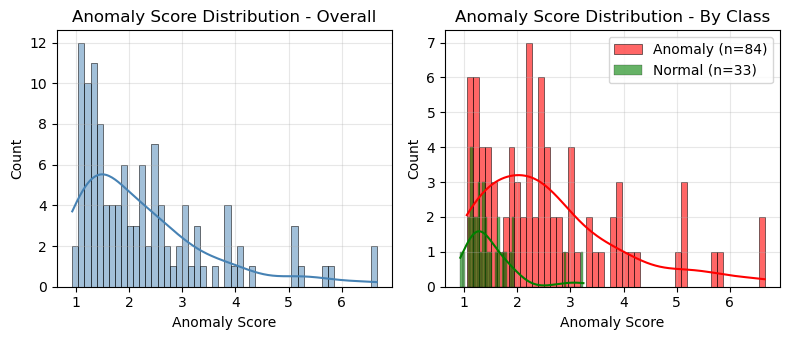

------------------------------------------------------------
EXPERIMENT RESULTS
------------------------------------------------------------
 > AUROC:             0.7994
 > AUPR:              0.9173
 > Threshold:         1.934e+00
------------------------------------------------------------
 > Accuracy:          0.7350
 > Precision:         0.9649
 > Recall:            0.6548
 > F1-Score:          0.7801
------------------------------------------------------------
                   Predicted
   Actual    Normal  Anomaly
   Normal        31        2
   Anomaly       29       55

DETAILED SCORE STATISTICS:
----------------------------------------
Normal  - Count:   33
          Mean:  1.475289 ± 0.484390
          Range: [0.925304, 3.244394]

Anomaly - Count:   84
          Mean:  2.592211 ± 1.313943
          Range: [1.047253, 6.660642]

SEPARATION ANALYSIS:
----------------------------------------
Cohen's d (effect size): 0.9754
 > EXCELLENT separation (Cohen's d > 0.8)


In [7]:
scores, labels = trainer_predict(model, test_loader, config.device, method='max_pooling')
show_roc_curve(scores, labels)
show_distribution(scores, labels)
show_evaluation(scores, labels)
show_statistics(scores, labels)

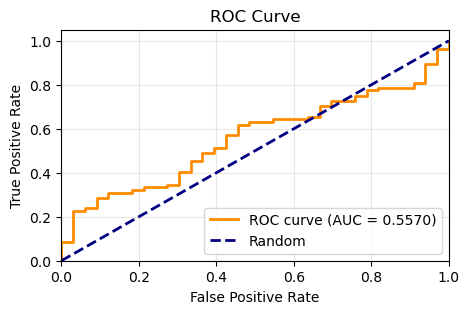

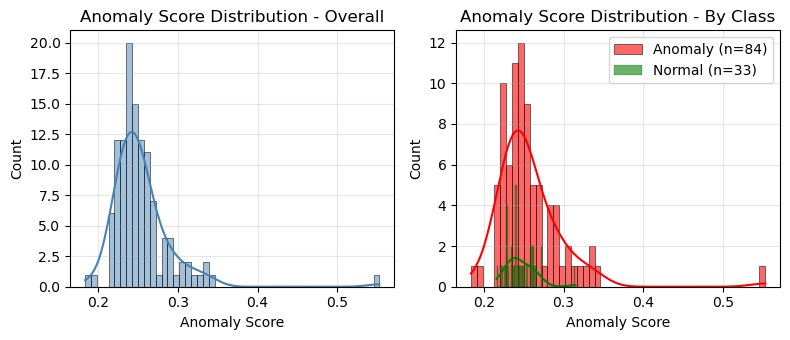

------------------------------------------------------------
EXPERIMENT RESULTS
------------------------------------------------------------
 > AUROC:             0.5570
 > AUPR:              0.7993
 > Threshold:         2.789e-01
------------------------------------------------------------
 > Accuracy:          0.4359
 > Precision:         0.9500
 > Recall:            0.2262
 > F1-Score:          0.3654
------------------------------------------------------------
                   Predicted
   Actual    Normal  Anomaly
   Normal        32        1
   Anomaly       65       19

DETAILED SCORE STATISTICS:
----------------------------------------
Normal  - Count:   33
          Mean:  0.246377 ± 0.018565
          Range: [0.215889, 0.314496]

Anomaly - Count:   84
          Mean:  0.257515 ± 0.044987
          Range: [0.183702, 0.552600]

SEPARATION ANALYSIS:
----------------------------------------
Cohen's d (effect size): 0.2823
 > FAIR separation (Cohen's d > 0.2)


In [8]:
scores, labels = trainer_predict(model, test_loader, config.device, method='percentile_95')
show_roc_curve(scores, labels)
show_distribution(scores, labels)
show_evaluation(scores, labels)
show_statistics(scores, labels)

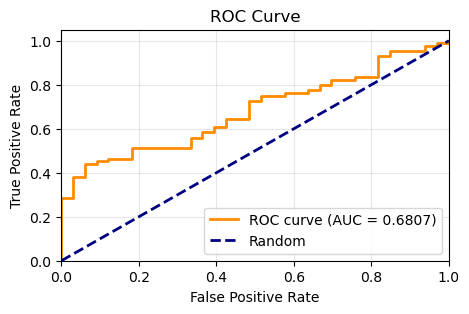

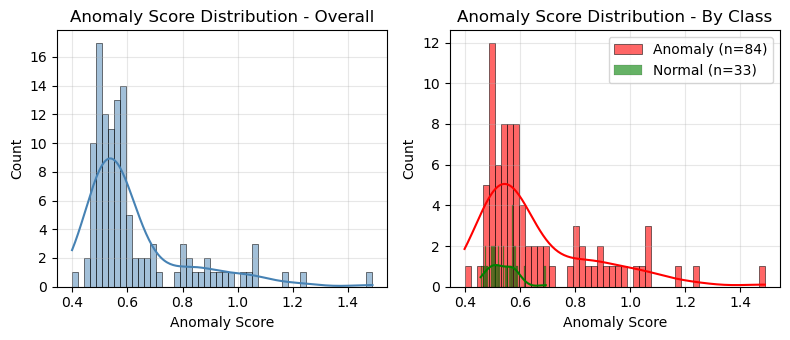

------------------------------------------------------------
EXPERIMENT RESULTS
------------------------------------------------------------
 > AUROC:             0.6807
 > AUPR:              0.8706
 > Threshold:         5.941e-01
------------------------------------------------------------
 > Accuracy:          0.5812
 > Precision:         0.9487
 > Recall:            0.4405
 > F1-Score:          0.6016
------------------------------------------------------------
                   Predicted
   Actual    Normal  Anomaly
   Normal        31        2
   Anomaly       47       37

DETAILED SCORE STATISTICS:
----------------------------------------
Normal  - Count:   33
          Mean:  0.536996 ± 0.049666
          Range: [0.457706, 0.693919]

Anomaly - Count:   84
          Mean:  0.660803 ± 0.208893
          Range: [0.399434, 1.488794]

SEPARATION ANALYSIS:
----------------------------------------
Cohen's d (effect size): 0.6902
 > GOOD separation (Cohen's d > 0.5)


In [9]:
scores, labels = trainer_predict(model, test_loader, config.device, method='topk_mean')
show_roc_curve(scores, labels)
show_distribution(scores, labels)
show_evaluation(scores, labels)
show_statistics(scores, labels)

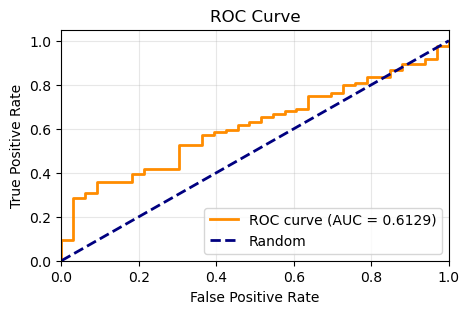

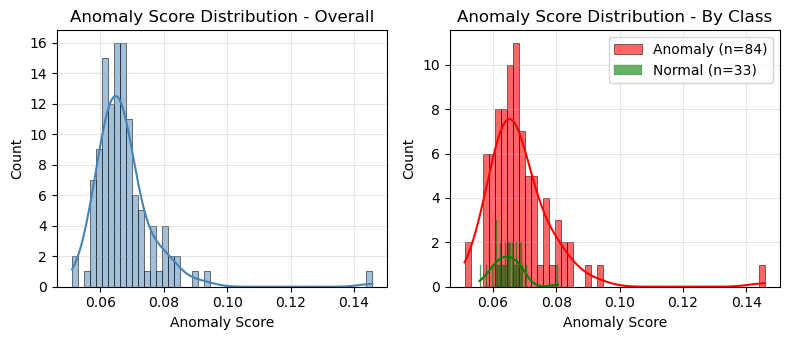

------------------------------------------------------------
EXPERIMENT RESULTS
------------------------------------------------------------
 > AUROC:             0.6129
 > AUPR:              0.8283
 > Threshold:         6.905e-02
------------------------------------------------------------
 > Accuracy:          0.5128
 > Precision:         0.9091
 > Recall:            0.3571
 > F1-Score:          0.5128
------------------------------------------------------------
                   Predicted
   Actual    Normal  Anomaly
   Normal        30        3
   Anomaly       54       30

DETAILED SCORE STATISTICS:
----------------------------------------
Normal  - Count:   33
          Mean:  0.064565 ± 0.004568
          Range: [0.055770, 0.080533]

Anomaly - Count:   84
          Mean:  0.068485 ± 0.011610
          Range: [0.051052, 0.145850]

SEPARATION ANALYSIS:
----------------------------------------
Cohen's d (effect size): 0.3861
 > FAIR separation (Cohen's d > 0.2)


In [10]:
scores, labels = trainer_predict(model, test_loader, config.device, method='mean')
show_roc_curve(scores, labels)
show_distribution(scores, labels)
show_evaluation(scores, labels)
show_statistics(scores, labels)